In [30]:
import pandas as pd
tracks = pd.read_csv("datasets/fma-rock-vs-hiphop.csv")
echonest_metrics = pd.read_json("datasets/echonest-metrics.json", precise_float= True)

echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
track_id            4802 non-null int64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [31]:
%%nose

def test_tracks_read():
    try:
        pd.testing.assert_frame_equal(tracks, pd.read_csv('datasets/fma-rock-vs-hiphop.csv'))
    except AssertionError:
        assert False, "The tracks data frame was not read in correctly."

def test_metrics_read():
    ech_met_test = pd.read_json('datasets/echonest-metrics.json', precise_float=True)
    try:
        pd.testing.assert_frame_equal(echonest_metrics, ech_met_test)
    except AssertionError:
        assert False, "The echonest_metrics data frame was not read in correctly."
        
def test_merged_shape(): 
    merged_test = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')
    try:
        pd.testing.assert_frame_equal(echo_tracks, merged_test)
    except AssertionError:
        assert False, ('The two datasets should be merged on matching track_id values '
                       'keeping only the track_id and genre_top columns of tracks.')

3/3 tests passed


In [32]:
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,track_id,valence
acousticness,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.372282,-0.0138406
danceability,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.0494541,0.473165
energy,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.140703,0.0386027
instrumentalness,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.275623,-0.219967
liveness,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,0.0482307,-0.0450931
speechiness,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,-0.0269951,0.149894
tempo,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,-0.0253918,0.0522212
track_id,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,1,0.0100698
valence,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,0.0100698,1


In [33]:
%%nose

def test_corr_matrix():
    assert all(corr_metrics == echonest_metrics.corr()) and isinstance(corr_metrics, pd.core.frame.DataFrame), \
        'The correlation matrix can be computed using the .corr() method.'

1/1 tests passed


In [34]:
from sklearn.model_selection import train_test_split

features = echo_tracks.drop(columns=['genre_top', 'track_id'], axis=1).values
labels = echo_tracks['genre_top'].values

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

In [35]:
%%nose

import sys

def test_features_labels():
    assert features.shape == (4802, 8), \
    """Did you drop "genre_top" from echo_tracks, and store all remaining values as features?"""
    assert labels.shape == (4802,), \
    """Did you store values from the "genre_top" column as labels?"""

def test_train_test_split_import():
    assert 'sklearn.model_selection' in list(sys.modules.keys()), \
    'Have you imported train_test_split from sklearn.model_selection?'
        
def test_train_test_split():
    train_test_res = train_test_split(features, labels, random_state=10)
    assert (train_features == train_test_res[0]).all(), \
    'Did you correctly call the train_test_split function?'
        
def test_correct_split():
    assert train_features.shape == (3601, 8), \
    """Did you correctly split the data? Expected a different shape for train_features."""
    assert test_features.shape == (1201, 8), \
    """Did you correctly split the data? Expected a different shape for test_features."""
    assert train_labels.shape == (3601,), \
    """Did you correctly split the data? Expected a different shape for train_labels."""
    assert test_labels.shape == (1201,), \
    """Did you correctly split the data? Expected a different shape for test_labels."""

4/4 tests passed


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [37]:
%%nose

import sys
import numpy as np

# def test_labels_df():
#     try:
#         pd.testing.assert_series_equal(labels, echo_tracks['genre_top'])
#     except AssertionError:
#         assert False, 'Does your labels DataFrame only contain the genre_top column?'
        
def test_standardscaler_import():
    assert 'sklearn.preprocessing' in list(sys.modules.keys()), \
    'The StandardScaler can be imported from sklearn.preprocessing.'
        
def test_scaled_features():
    assert scaled_train_features[0].tolist() == [-1.3189452160155823,
 -1.748936113215404,
 0.5183796247907855,
 -0.2981419458739739,
 -0.19909374640763283,
 -0.41175479316875396,
 -0.911269482360871,
 -0.3436413082337475], \
    "Use the StandardScaler's fit_transform method on train_features."
    assert scaled_test_features[0].tolist() == [-1.3182917030552226,
 -1.6238218896488739,
 1.3841707828629735,
 -1.3119421397560926,
 2.1929908647262364,
 0.03499652489786962,
 1.9228785168921492,
 -0.2813786091336706], \
    "Use the StandardScaler's transform method on test_features."

2/2 tests passed


Text(0.5,0,'Principal Component #')

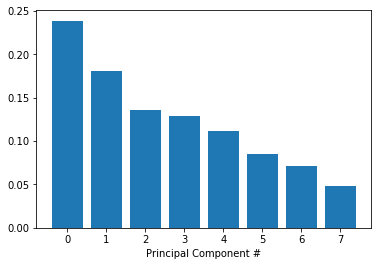

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

In [39]:
%%nose

import sklearn
import numpy as np
import sys

def test_pca_import():
    assert ('sklearn.decomposition' in list(sys.modules.keys())), \
    'Have you imported the PCA object from sklearn.decomposition?'

def test_pca_obj():
    assert isinstance(pca, sklearn.decomposition.PCA), \
    "Use scikit-learn's PCA() object to create your own PCA object here."
        
def test_exp_variance():
    rounded_array = exp_variance
    rounder = lambda t: round(t, ndigits = 2)
    vectorized_round = np.vectorize(rounder)
    assert (vectorized_round(exp_variance)).all() == np.array([0.24, 0.18, 0.14, 0.13, 0.11, 0.09, 0.07, 0.05]).all(), \
    'Following the PCA fit, the explained variance ratios can be obtained via the explained_variance_ratio_ method.'
        
def test_scree_plot():
    expected_xticks = [float(n) for n in list(range(-1, 9))]
    assert list(ax.get_xticks()) == expected_xticks, \
    'Plot the number of pca components (on the x-axis) against the explained variance (on the y-axis).'

4/4 tests passed


## Further visualization of PCA

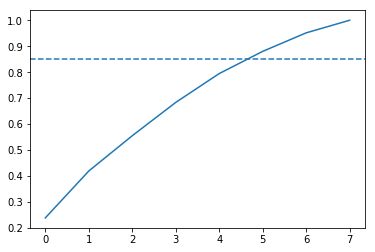

In [40]:
import numpy as np
cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [41]:
%%nose

import sys

def test_np_import():
    assert 'numpy' in list(sys.modules.keys()), \
    'Have you imported numpy?'

def test_cumsum():
    cum_exp_variance_correct = np.cumsum(exp_variance)
    assert all(cum_exp_variance == cum_exp_variance_correct), \
    'Use np.cumsum to calculate the cumulative sum of the exp_variance array.'
    
# def test_n_comp():
#     assert n_components == 5, \
#     ('Check the values in cum_exp_variance if it is difficult '
#     'to determine the number of components from the plot.')
    
    
# def test_trans_pca():
#     pca_test = PCA(n_components, random_state=10)
#     pca_test.fit(scaled_train_features)
#     assert (pca_projection == pca_test.transform(scaled_train_features)).all(), \
#     'Transform the scaled features and assign them to the pca_projection variable.'

2/2 tests passed


In [42]:
pca = PCA(n_components = 6, random_state = 10)

train_pca = pca.fit_transform(scaled_train_features)
test_pca = pca.transform(scaled_test_features)

In [43]:
%%nose

import sys
import sklearn

def test_pca_import():
    assert ('sklearn.decomposition' in list(sys.modules.keys())), \
    'Have you imported the PCA object from sklearn.decomposition?'
    
def test_pca_obj():
    assert isinstance(pca, sklearn.decomposition.PCA), \
    "Use scikit-learn's PCA() object to create your own PCA object here."    
    
def test_trans_pca():
    pca_copy = PCA(n_components=6, random_state=10)
    pca_copy.fit(scaled_train_features)
    assert train_pca.all() == pca_copy.transform(scaled_train_features).all(), \
    'Fit and transform the scaled training features and assign them to the train_pca variable.'
    pca_test = pca_copy.transform(scaled_test_features)
    assert test_pca.all() == pca_copy.transform(scaled_test_features).all()

3/3 tests passed


## Train a decision tree to classify genre

<p><img src="https://assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

In [44]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=10)

tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

In [45]:
%%nose

import sys

# def test_train_test_split_import():
#     assert 'sklearn.model_selection' in list(sys.modules.keys()), \
#         'Have you imported train_test_split from sklearn.model_selection?'

    
def test_decision_tree_import():
    assert 'sklearn.tree' in list(sys.modules.keys()), \
    'Have you imported DecisionTreeClassifier from sklearn.tree?'
    
    
# def test_train_test_split():
#     train_test_res = train_test_split(pca_projection, labels, random_state=10)
#     assert (train_features == train_test_res[0]).all(), \
#         'Did you correctly call the train_test_split function?'
    
    
def test_tree():
    assert tree.get_params() == DecisionTreeClassifier(random_state=10).get_params(), \
    'Did you create the decision tree correctly?'
    
    
def test_tree_fit():
    assert hasattr(tree, 'classes_'), \
    'Did you fit the tree to the training data?'
    
    
def test_tree_pred():
    assert (pred_labels_tree == 'Rock').sum() == 971, \
    'Did you correctly use the fitted tree object to make a prediction from test_pca?'

4/4 tests passed


## Compare decision tree to a logistic regression


In [46]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state= 10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.70      0.70      0.70       229
       Rock       0.93      0.93      0.93       972

avg / total       0.88      0.88      0.88      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.76      0.57      0.65       229
       Rock       0.90      0.96      0.93       972

avg / total       0.88      0.88      0.88      1201



In [47]:
%%nose

def test_logreg():
    assert logreg.get_params() == LogisticRegression(random_state=10).get_params(), \
    'The logreg variable should be created using LogisticRegression().'

    
def test_logreg_pred():
    assert abs((pred_labels_logit == 'Rock').sum() - 1028) < 7, \
    'The labels should be predicted from the test_features.'
    
    
def test_class_rep_tree():
    assert isinstance(class_rep_tree, str), \
    'Did you create the classification report correctly for the decision tree?'
    
    
def test_class_rep_log():
    assert isinstance(class_rep_log, str), \
    'Did you create the classification report correctly for the logistic regression?'

4/4 tests passed


In [48]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only =echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

rock_only = rock_only.sample(hop_only.shape[0], random_state=10)
rock_hop_bal = pd.concat([rock_only, hop_only])
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)
train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

In [49]:
%%nose

def test_hop_only():
    try:
        pd.testing.assert_frame_equal(hop_only, echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop'])
    except AssertionError:
        assert False, "The hop_only data frame was not assigned correctly."
        

def test_rock_only():
    try:
        pd.testing.assert_frame_equal(
            rock_only, echo_tracks.loc[echo_tracks['genre_top'] == 'Rock'].sample(hop_only.shape[0], random_state=10))
    except AssertionError:
        assert False, "The rock_only data frame was not assigned correctly."
        
        
def test_rock_hop_bal():
    hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
    rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock'].sample(hop_only.shape[0], random_state=10)
    try:
        pd.testing.assert_frame_equal(
            rock_hop_bal, pd.concat([rock_only, hop_only]))
    except AssertionError:
        assert False, "The rock_hop_bal data frame was not assigned correctly."
        
        
def test_train_features():
    assert round(train_pca[0][0], 4) == -0.6434 and round(test_pca[0][0], 4) == 0.4368, \
    'The train_test_split was not performed correctly.'

4/4 tests passed


In [50]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.79      0.77       230
       Rock       0.77      0.73      0.75       225

avg / total       0.76      0.76      0.76       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.81      0.83      0.82       230
       Rock       0.83      0.80      0.82       225

avg / total       0.82      0.82      0.82       455



In [51]:
%%nose

def test_tree_bal():
    assert (pred_labels_tree == 'Rock').sum() == 213, \
    'The pred_labels_tree variable should contain the predicted labels from the test_features.'
    
    
def test_logit_bal():
    assert (pred_labels_logit == 'Rock').sum() == 219, \
    'The pred_labels_logit variable should contain the predicted labels from the test_features.'

2/2 tests passed


## Using cross-validation to evaluate models

In [52]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

kf = KFold(n_splits= 10)

tree_score = cross_val_score(tree_pipe, features, labels,cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels,cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7219780219780221 Logistic Regression: 0.773076923076923


In [53]:
%%nose

def test_kf():
    assert kf.__repr__() == 'KFold(n_splits=10, random_state=None, shuffle=False)', \
    'The k-fold cross-validation was not setup correctly.'
    
    
def test_tree_score():
    assert np.isclose(round((tree_score.sum() / tree_score.shape[0]), 4), 0.722, atol=1e-3), \
    'The tree_score was not calculated correctly.'
    
    
def test_log_score():
    assert np.isclose(round((logit_score.sum() / logit_score.shape[0]), 4), 0.7731, atol=1e-3), \
    'The logit_score was not calculated correctly.'

3/3 tests passed
